# Visualization of experiment runs

This notebook serves the purpose of visualizing experimental data generated by the experiment scripts in the project folder of this repository. To visualize, by default, pre-generated data of our experimentation runs in the `data` folder is used. If you want to change this, you need to ensure to generate new results which then can be loaded in here by executing the corresponding section's code.

In [40]:
# Allows to make changes to the classes without restarting the notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


General dependencies

In [41]:
from src.model.agents.Hive import Hive
from src.model.agents.BeeSwarm import BeeSwarm
from src.model.agents.Resource import Resource
from src.model.Model import ForagerModel

from src.model.config.HiveConfig import HiveConfig
from src.model.config.BeeSwarmConfig import BeeSwarmConfig
from src.model.config.ResourceConfig import ResourceConfig
from src.model.config.ModelConfig import ModelConfig

from src.model.util.BeeState import BeeState
import src.model.util.ModelBuilder as ModelBuilder

In [42]:
import mesa
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta, expon
from tqdm.notebook import tqdm
from multiprocess.pool import Pool
from scipy import interpolate
import os

In [43]:
FIGURE_PATH = "figures/"

# Baseline model dynamic visualization

In [44]:
from experiment_baseline_dynamics import BEE_COUNT_FILE, NECTAR_FILE, RECRUITED_FILE, EXPLORERS_FILE

In [45]:
BEE_COUNT_DATA = np.load(BEE_COUNT_FILE)
NECTAR_DATA = np.load(NECTAR_FILE)
EXPLORERS_DATA = np.load(EXPLORERS_FILE)
RECRUITED_DATA = np.load(RECRUITED_FILE)

TRUNCATE_THRESHOLD = 1000
SURVIVAL_THRESHOLD = 100

BEE_COUNT_DATA = BEE_COUNT_DATA[:, :TRUNCATE_THRESHOLD]
NECTAR_DATA = NECTAR_DATA[:, :TRUNCATE_THRESHOLD]
EXPLORERS_DATA = EXPLORERS_DATA[:, :TRUNCATE_THRESHOLD]
RECRUITED_DATA = RECRUITED_DATA[:, :TRUNCATE_THRESHOLD]
FORAGER_DATA = EXPLORERS_DATA + RECRUITED_DATA

FINAL_BEE_COUNT = BEE_COUNT_DATA[:, -1]

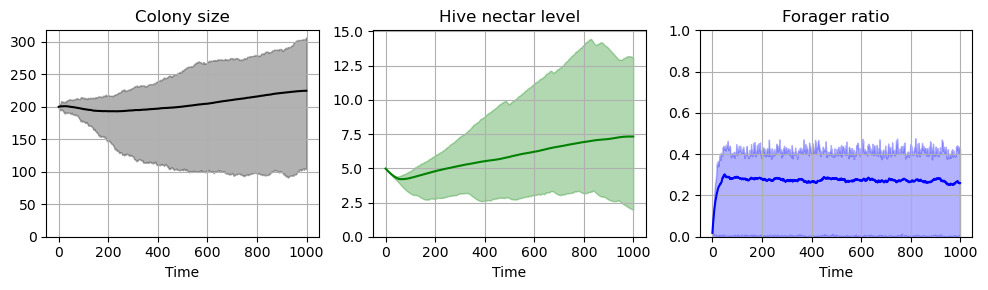

In [46]:
TIME = np.arange(0, BEE_COUNT_DATA.shape[1])

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].fill_between(TIME, np.max(BEE_COUNT_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), np.min(BEE_COUNT_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="black", alpha=0.3)
axes[0].plot(TIME, np.mean(BEE_COUNT_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="black")
axes[0].set_title("Colony size")

axes[1].fill_between(TIME, np.max(NECTAR_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), np.min(NECTAR_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="green", alpha=0.3)
axes[1].plot(TIME, np.mean(NECTAR_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="green")
axes[1].set_title("Hive nectar level")

axes[2].fill_between(TIME, np.max(FORAGER_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), np.min(FORAGER_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="blue", alpha=0.3)
axes[2].plot(TIME, np.mean(FORAGER_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="blue")
axes[2].set_title("Forager ratio")
axes[2].set_ylim(0,1)

for ax in axes:
    ax.set_xlabel("Time")
    ax.set_ylim(0,)
    ax.grid()

plt.tight_layout()
plt.savefig(FIGURE_PATH + "baseline_dynamics_1.png")
plt.show()

Surviving / deceased colonies (final bee count below 150)

In [47]:
print(f"{np.round(BEE_COUNT_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD].shape[0] / BEE_COUNT_DATA.shape[0] * 100, 2)}% colonies survived")
print(f"{np.round(BEE_COUNT_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD].shape[0] / BEE_COUNT_DATA.shape[0] * 100, 2)}% colonies deceased")

69.53% colonies survived
30.47% colonies deceased


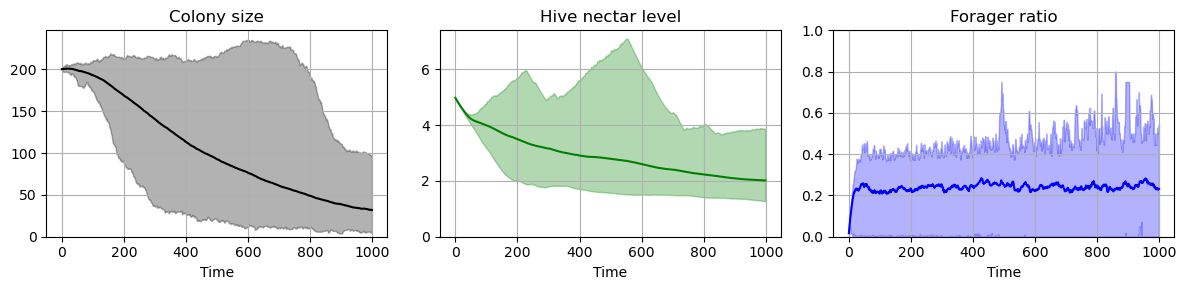

In [9]:
TIME = np.arange(0, BEE_COUNT_DATA.shape[1])

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].fill_between(TIME, np.max(BEE_COUNT_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), np.min(BEE_COUNT_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="black", alpha=0.3)
axes[0].plot(TIME, np.mean(BEE_COUNT_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="black")
axes[0].set_title("Colony size")

axes[1].fill_between(TIME, np.max(NECTAR_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), np.min(NECTAR_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="green", alpha=0.3)
axes[1].plot(TIME, np.mean(NECTAR_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="green")
axes[1].set_title("Hive nectar level")

axes[2].fill_between(TIME, np.max(FORAGER_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), np.min(FORAGER_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="blue", alpha=0.3)
axes[2].plot(TIME, np.mean(FORAGER_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="blue")
axes[2].set_title("Forager ratio")
axes[2].set_ylim(0,1)

for ax in axes:
    ax.set_xlabel("Time")
    ax.set_ylim(0,)
    ax.grid()

plt.tight_layout()
plt.savefig(FIGURE_PATH + "baseline_dynamics_2.png")
plt.show()

# Resource scarcity experiment

In [10]:
from experiment_resource_scarcity import N_RESOURCES, DIST_RESOURCES, BEE_COUNT_FILE, NECTAR_FILE

In [11]:
BEE_COUNT_DATA = np.load(BEE_COUNT_FILE)
NECTAR_DATA = np.load(NECTAR_FILE)

In [12]:
BEE_COUNT = BEE_COUNT_DATA[:, :, :, -1]

BEE_COUNT_SD = np.std(BEE_COUNT, axis=2)
BEE_COUNT_MEAN = np.mean(BEE_COUNT, axis=2)

NECTAR = NECTAR_DATA[:, :, :, -1]

NECTAR_SD = np.std(NECTAR, axis=2)
NECTAR_MEAN = np.mean(NECTAR, axis=2)

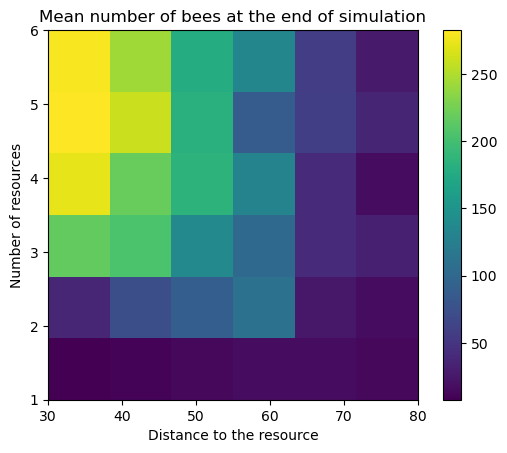

In [13]:
plot = plt.imshow(BEE_COUNT_MEAN, extent=(DIST_RESOURCES[0], DIST_RESOURCES[-1], N_RESOURCES[0], N_RESOURCES[-1]), aspect=10, origin="lower")
plt.xlabel("Distance to the resource")
plt.ylabel("Number of resources")
plt.title("Mean number of bees at the end of simulation")
plt.colorbar(plot)
plt.savefig(FIGURE_PATH + "resource_scarcity_2d.png")

/var/folders/tg/bfb__1d16td__2vd879zjkrh0000gn/T/ipykernel_54291/375015010.py:9: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=9,12 m=36 fp=0.368569 s=0.000000
  TCK = interpolate.bisplrep(X, Y, data, s=0)


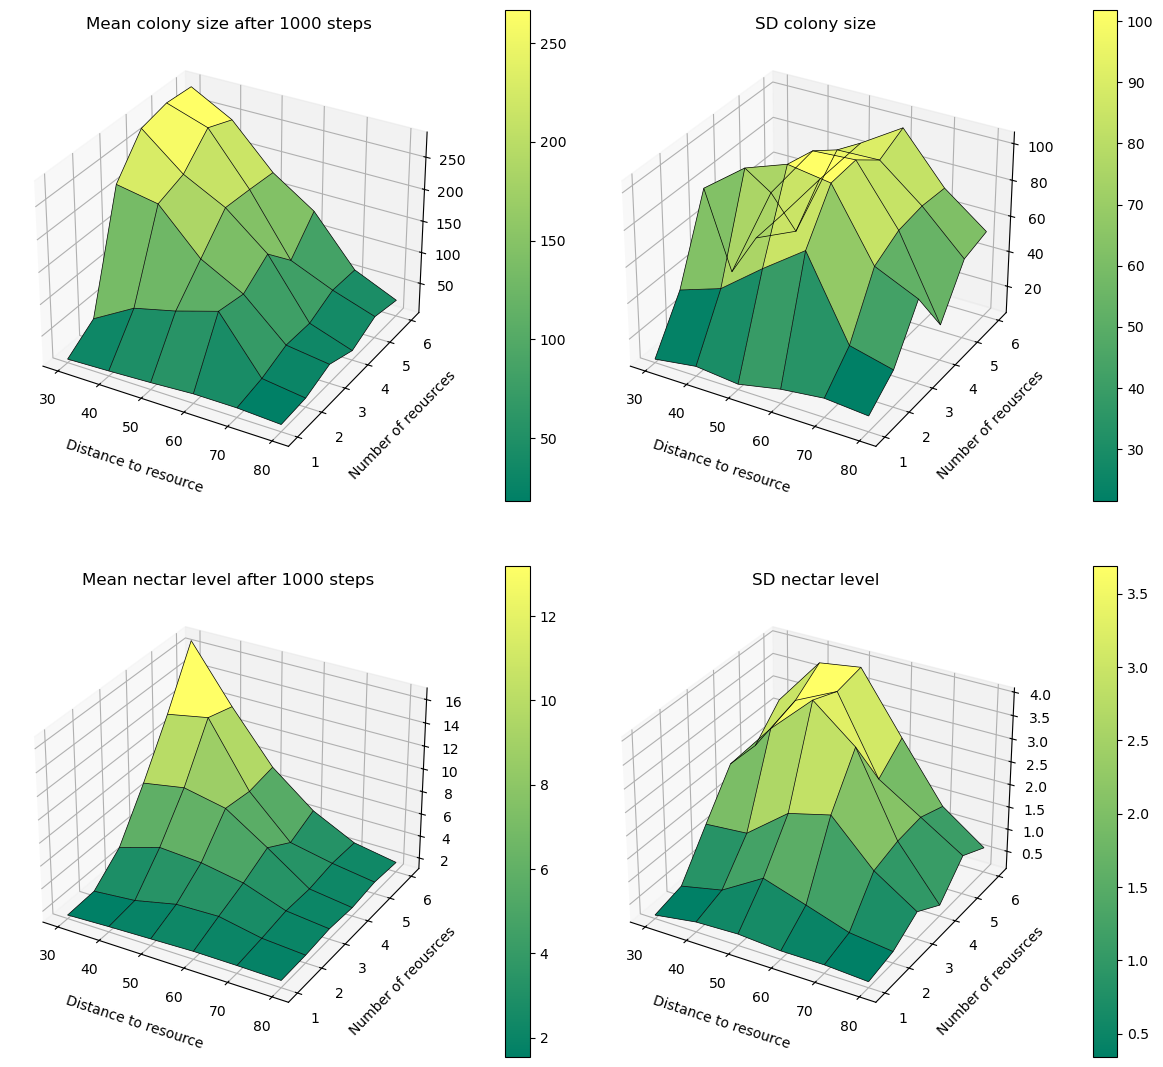

In [14]:
X, Y = np.meshgrid(DIST_RESOURCES, N_RESOURCES)
X_INTERP, Y_INTERP = np.meshgrid(np.linspace(DIST_RESOURCES[0], DIST_RESOURCES[-1], 100), np.linspace(N_RESOURCES[0], N_RESOURCES[-1], 100))

fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 12))
plot_data = [BEE_COUNT_MEAN, BEE_COUNT_SD, NECTAR_MEAN, NECTAR_SD]

for (data, ax) in zip(plot_data, axes.flatten()):
    # Smooth out data
    TCK = interpolate.bisplrep(X, Y, data, s=0)
    Z_INTERP = interpolate.bisplev(X_INTERP[:,0], Y_INTERP[0,:], TCK)
    Z = data

    # Plot data
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.summer, alpha=None, antialiased=True)
    ax.plot_wireframe(X, Y, Z, lw=0.5, color='black', alpha=None, antialiased=True)

    # Plot settings & colorbar
    ax.set_xlabel("Distance to resource", labelpad=10.0)
    ax.set_xticks(DIST_RESOURCES)

    ax.set_ylabel("Number of reousrces", labelpad=10.0)
    ax.set_yticks(N_RESOURCES)

    fig.colorbar(surf, ax=ax, shrink=0.8, aspect=20, pad=0.1)

axes[0,0].set_title("Mean colony size after 1000 steps")

axes[0,1].set_title("SD colony size")

axes[1,0].set_title("Mean nectar level after 1000 steps")

axes[1,1].set_title("SD nectar level")

plt.tight_layout()
plt.savefig(FIGURE_PATH + "resource_scarcity_3d.png", bbox_inches='tight')
plt.show()

# Weather effects experiment

In [15]:
from experiment_weather_effects import P_STORMS, STORM_DURATIONS, BEE_COUNT_FILE, NECTAR_FILE, EXPLORERS_FILE, RECRUITED_FILE

In [16]:
BEE_COUNT_DATA = np.load(BEE_COUNT_FILE)
NECTAR_DATA = np.load(NECTAR_FILE)
EXPLORERS_DATA = np.load(EXPLORERS_FILE)
RECRUITED_DATA = np.load(RECRUITED_FILE)

FORAGER_DATA = EXPLORERS_DATA + RECRUITED_DATA

In [17]:
BEE_COUNT = BEE_COUNT_DATA[:, :, :, -1]

BEE_COUNT_SD = np.std(BEE_COUNT, axis=2)
BEE_COUNT_MEAN = np.mean(BEE_COUNT, axis=2)

FORAGERS = np.mean(FORAGER_DATA, axis=3)

FORAGERS_SD = np.std(FORAGERS, axis=2)
FORAGERS_MEAN = np.mean(FORAGERS, axis=2)

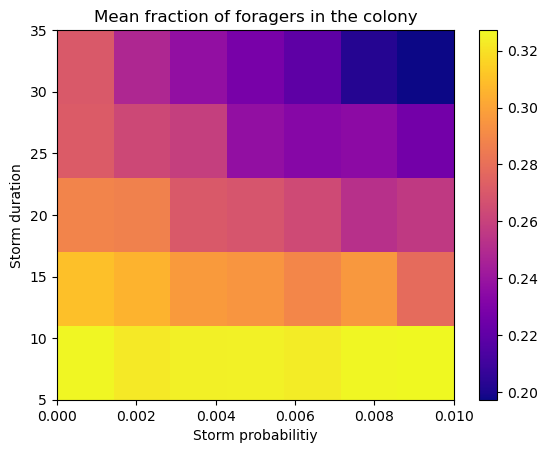

In [18]:
plot = plt.imshow(FORAGERS_MEAN, extent=(P_STORMS[0], P_STORMS[-1], STORM_DURATIONS[0], STORM_DURATIONS[-1]), aspect='auto', origin="lower", cmap="plasma")
plt.xlabel("Storm probabilitiy")
plt.ylabel("Storm duration")
plt.title("Mean fraction of foragers in the colony")
plt.colorbar(plot)
plt.savefig(FIGURE_PATH + "weather_effects_2d.png")

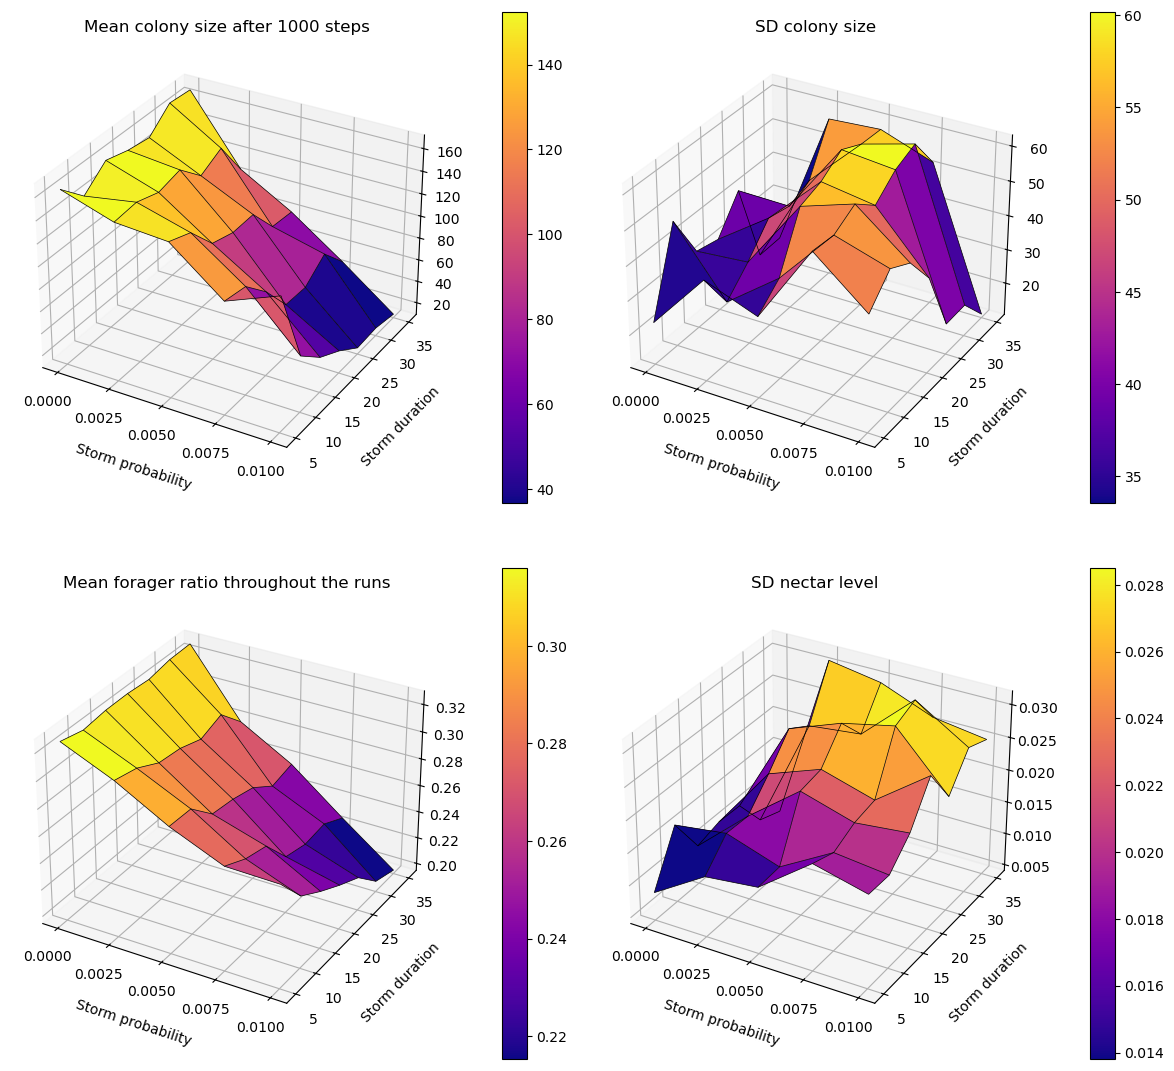

In [19]:
X, Y = np.meshgrid(P_STORMS, STORM_DURATIONS)
X_INTERP, Y_INTERP = np.meshgrid(np.linspace(P_STORMS[0], P_STORMS[-1], 100), np.linspace(STORM_DURATIONS[0], STORM_DURATIONS[-1], 100))

fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 12))
plot_data = [BEE_COUNT_MEAN, BEE_COUNT_SD, FORAGERS_MEAN, FORAGERS_SD]

for (data, ax) in zip(plot_data, axes.flatten()):
    Z = data

    # Plot data
    surf = ax.plot_surface(X, Y, Z.T, cmap=plt.cm.plasma, alpha=None, antialiased=True)
    ax.plot_wireframe(X, Y, Z.T, lw=0.5, color='black', alpha=None, antialiased=True)

    # Plot settings & colorbar
    ax.set_xlabel("Storm probability", labelpad=10.0)
    ax.set_xticks(P_STORMS)

    ax.set_ylabel("Storm duration", labelpad=10.0)
    ax.set_yticks(STORM_DURATIONS)

    fig.colorbar(surf, ax=ax, shrink=0.8, aspect=20, pad=0.1)

axes[0,0].set_title("Mean colony size after 1000 steps")

axes[0,1].set_title("SD colony size")

axes[1,0].set_title("Mean forager ratio throughout the runs")

axes[1,1].set_title("SD nectar level")

plt.tight_layout()
plt.savefig(FIGURE_PATH + "weather_effects_3d.png", bbox_inches='tight')
plt.show()

# Resource clustering experiment

### Setup

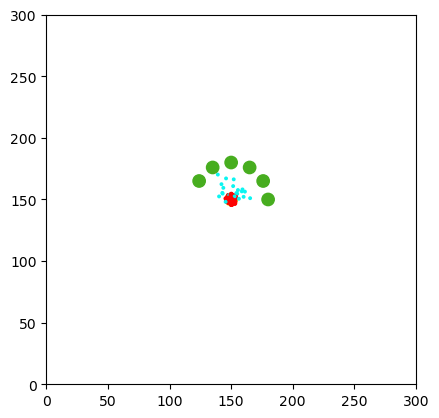

In [20]:
N_RESOURCES = 6

model = ForagerModel()

max_angles = np.arange(2*np.pi / 6, 2*np.pi, 2*np.pi / 6)
ModelBuilder.add_n_resources_in_angle_range(model, 30, 6, max_angles[2])

for _ in range(10):
    model.step()

fig, ax = plt.subplots()
model.plot(ax)

plt.show()

### Results

In [21]:
from experiment_resource_clustering import N_RESOURCE, DIST_RESOURCES, MAX_ANGLES, BEE_COUNT_FILE, NECTAR_FILE, EXPLORERS_FILE, RECRUITED_FILE

In [22]:
BEE_COUNT_DATA = np.load(BEE_COUNT_FILE)
NECTAR_DATA = np.load(NECTAR_FILE)
EXPLORERS_DATA = np.load(EXPLORERS_FILE)
RECRUITED_DATA = np.load(RECRUITED_FILE)

FORAGER_DATA = EXPLORERS_DATA + RECRUITED_DATA

In [23]:
BEE_COUNT = BEE_COUNT_DATA[:, :, :, -1]

BEE_COUNT_SD = np.std(BEE_COUNT, axis=2)
BEE_COUNT_MEAN = np.mean(BEE_COUNT, axis=2)

FORAGERS = np.mean(FORAGER_DATA, axis=3)

FORAGERS_SD = np.std(FORAGERS, axis=2)
FORAGERS_MEAN = np.mean(FORAGERS, axis=2)

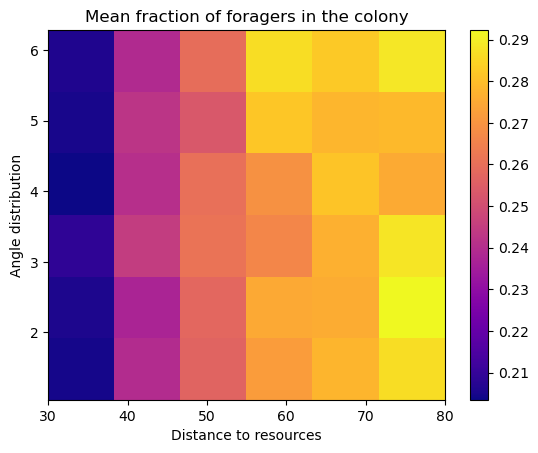

In [24]:
plot = plt.imshow(FORAGERS_MEAN, extent=(DIST_RESOURCES[0], DIST_RESOURCES[-1], MAX_ANGLES[0], MAX_ANGLES[-1]), aspect='auto', origin="lower", cmap="plasma")
plt.xlabel("Distance to resources")
plt.ylabel("Angle distribution")
plt.title("Mean fraction of foragers in the colony")
plt.colorbar(plot)
plt.savefig(FIGURE_PATH + "resource_clustering_2d.png")

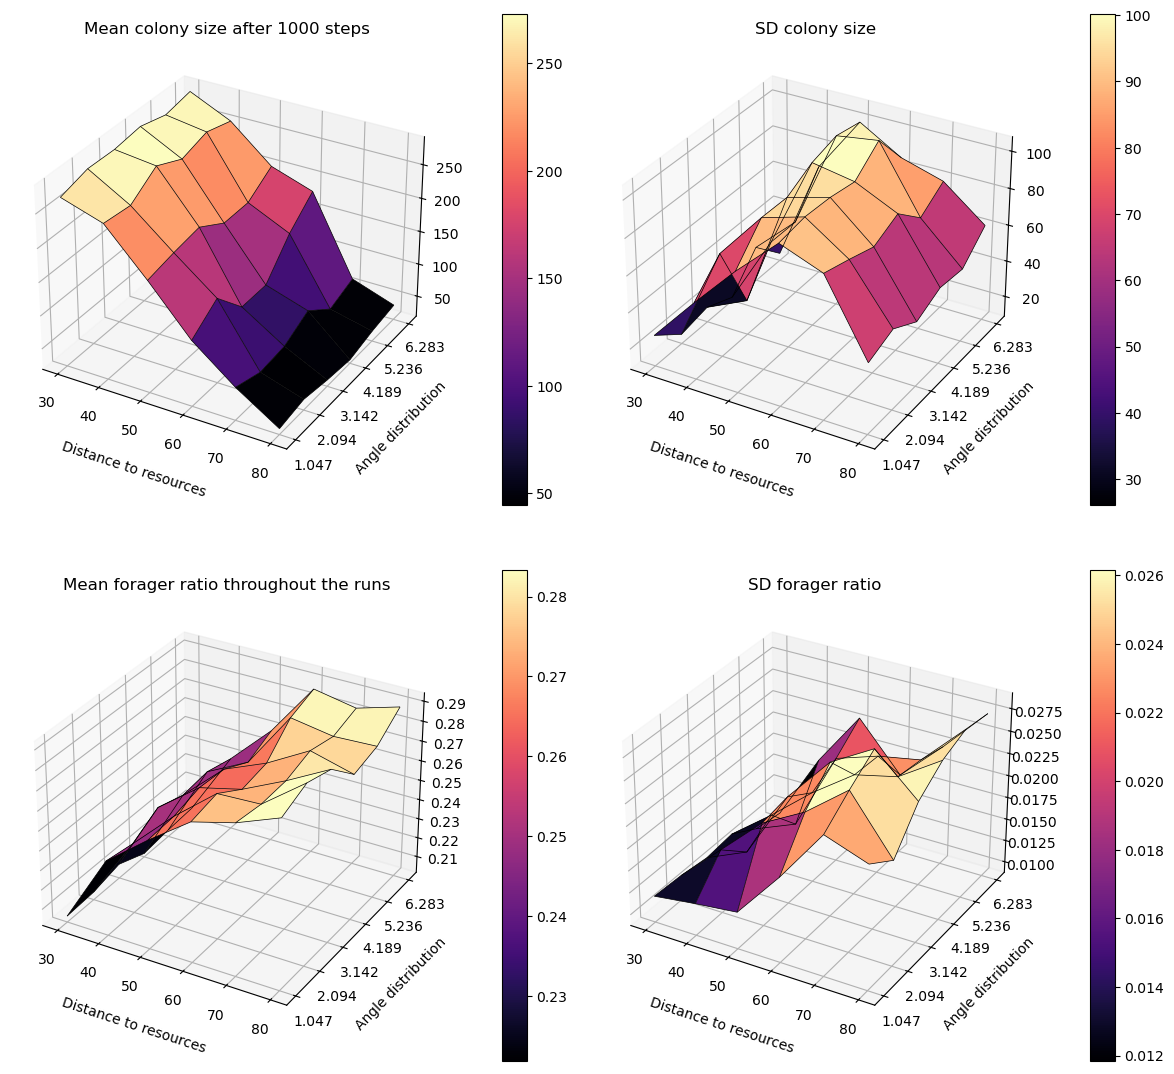

In [25]:
X, Y = np.meshgrid(DIST_RESOURCES, MAX_ANGLES)

fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 12))
plot_data = [BEE_COUNT_MEAN, BEE_COUNT_SD, FORAGERS_MEAN, FORAGERS_SD]

for (data, ax) in zip(plot_data, axes.flatten()):
    Z = data

    # Plot data
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.magma, alpha=None, antialiased=True)
    ax.plot_wireframe(X, Y, Z, lw=0.5, color='black', alpha=None, antialiased=True)

    # Plot settings & colorbar
    ax.set_xlabel("Distance to resources", labelpad=10.0)
    ax.set_xticks(DIST_RESOURCES)

    ax.set_ylabel("Angle distribution", labelpad=10.0)
    ax.set_yticks(MAX_ANGLES)

    fig.colorbar(surf, ax=ax, shrink=0.8, aspect=20, pad=0.1)

axes[0,0].set_title("Mean colony size after 1000 steps")

axes[0,1].set_title("SD colony size")

axes[1,0].set_title("Mean forager ratio throughout the runs")

axes[1,1].set_title("SD forager ratio")

plt.tight_layout()
plt.savefig(FIGURE_PATH + "resource_clustering_3d.png", bbox_inches='tight')
plt.show()

# Sensitivity analysis

In [26]:
PLOT_TITLES = ['Final colony size', 'Final hive stock', 'Final forager ratio']
PLOT_COLORS = ['dodgerblue', 'mediumturquoise', 'limegreen']

## a) Initial conditions

In [28]:
from ofat_sensitivity_analysis_initial_conditions import PARAMS, PROBLEM, N_SAMPLES, DATA_COLLECTORS, SAVE_PATH

FIGSIZE_SCALE = 12

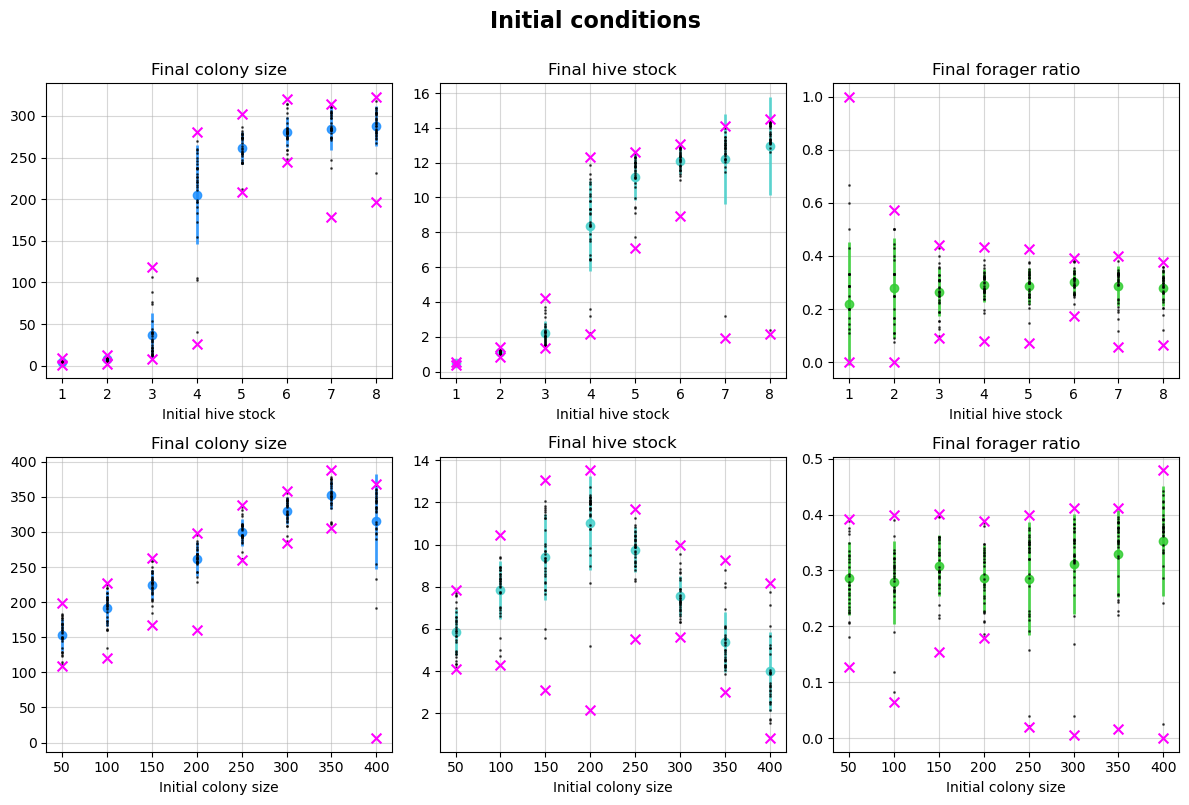

In [29]:
fig, axes = plt.subplots(len(PARAMS), len(DATA_COLLECTORS), figsize=(FIGSIZE_SCALE,FIGSIZE_SCALE/3*len(PARAMS)))

AXIS_LABELS = ['Initial hive stock', 'Initial colony size']

for (i, PARAM) in enumerate(PARAMS):
    DATA = np.load(os.path.join(SAVE_PATH,  PARAM + ".npy"))
    DOMAIN = np.linspace(PROBLEM['bounds'][i][0], PROBLEM['bounds'][i][1], N_SAMPLES)

    for X_POINT in DOMAIN:
        DATA_CHUNK = DATA[DATA[:, 0] == X_POINT]

        for (k, ax) in enumerate(axes[i]):

            # Mean and standard deviation
            ax.errorbar(X_POINT, np.mean(DATA_CHUNK[:, k + 1]), np.std(DATA_CHUNK[:, k + 1]), fmt="o", color=f"{PLOT_COLORS[k]}", lw=2.0, alpha=0.85)

            # All data point
            for Y_POINT in DATA_CHUNK[:, k + 1]:
                ax.scatter(X_POINT, Y_POINT, c='k', s=1.0, zorder=10, alpha=0.6)
            
            # Min and max
            ax.scatter(X_POINT, np.max(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')
            ax.scatter(X_POINT, np.min(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')

        for j, (name, ax) in enumerate(zip(PLOT_TITLES, axes[i])):
            ax.grid(alpha=0.5)
            ax.set_xticks(DOMAIN)
            ax.ticklabel_format(axis='x', style='scientific', scilimits=(-3,3))
            ax.set_xlabel(AXIS_LABELS[i])
            ax.set_title(PLOT_TITLES[j])

plt.suptitle('Initial conditions', weight='bold', y=1.0, fontsize=16)
fig.tight_layout()
plt.savefig(FIGURE_PATH + "sa_initial_conditions.png")
plt.show()

## b) Bee's FOV and food consumption

In [30]:
from ofat_sensitivity_analysis_bee_parameters import GENERAL_PARAMS, PROBLEM, N_SAMPLES, DATA_COLLECTORS, SAVE_PATH

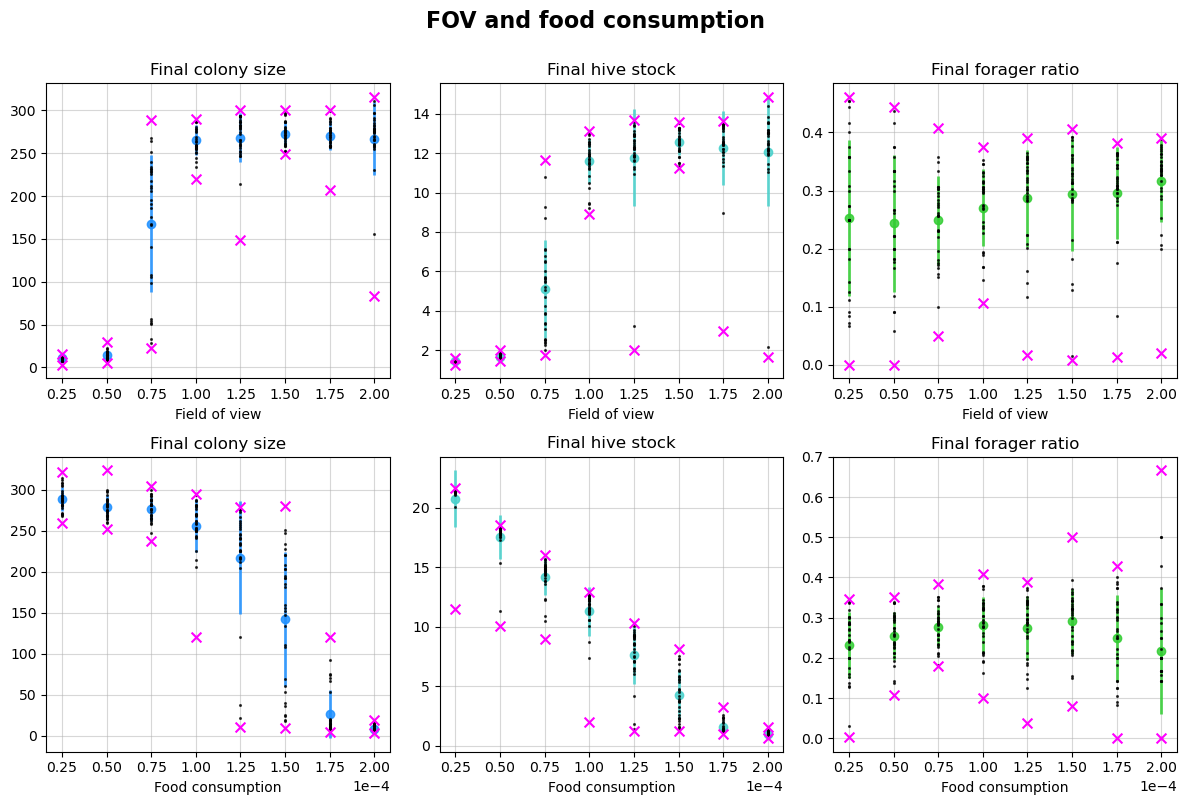

In [31]:
fig, axes = plt.subplots(len(GENERAL_PARAMS), len(DATA_COLLECTORS), figsize=(FIGSIZE_SCALE,FIGSIZE_SCALE/3*len(PARAMS)))

PLOT_TITLES = ['Final colony size', 'Final hive stock', 'Final forager ratio']
AXIS_LABELS = ['Field of view', 'Food consumption']

for (i, PARAM) in enumerate(GENERAL_PARAMS):
    DATA = np.load(os.path.join(SAVE_PATH, PARAM + ".npy"))
    DOMAIN = np.linspace(PROBLEM['bounds'][i][0], PROBLEM['bounds'][i][1], N_SAMPLES)

    for X_POINT in DOMAIN:
        DATA_CHUNK = DATA[DATA[:, 0] == X_POINT]

        for (k, ax) in enumerate(axes[i]):

            # Mean and standard deviation
            ax.errorbar(X_POINT, np.mean(DATA_CHUNK[:, k + 1]), np.std(DATA_CHUNK[:, k + 1]), fmt="o", color=f"{PLOT_COLORS[k]}", lw=2.0, alpha=0.85)

            # All data point
            for Y_POINT in DATA_CHUNK[:, k + 1]:
                ax.scatter(X_POINT, Y_POINT, c='k', s=1.5, zorder=10, alpha=0.7)
            
            # Min and max
            ax.scatter(X_POINT, np.max(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')
            ax.scatter(X_POINT, np.min(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')

    for j, (name, ax) in enumerate(zip(PLOT_TITLES, axes[i])):
        ax.grid(alpha=0.5)
        ax.set_xticks(DOMAIN)
        ax.ticklabel_format(axis='x', style='scientific', scilimits=(-3,3))
        ax.set_xlabel(AXIS_LABELS[i])
        ax.set_title(PLOT_TITLES[j])


plt.suptitle('FOV and food consumption', weight='bold', y=1.0, fontsize=16)
fig.tight_layout()
plt.savefig(FIGURE_PATH + "sa_fov_food.png")
plt.show()

In [32]:
from ofat_sensitivity_analysis_bee_parameters import MOVEMENT_PARAMS

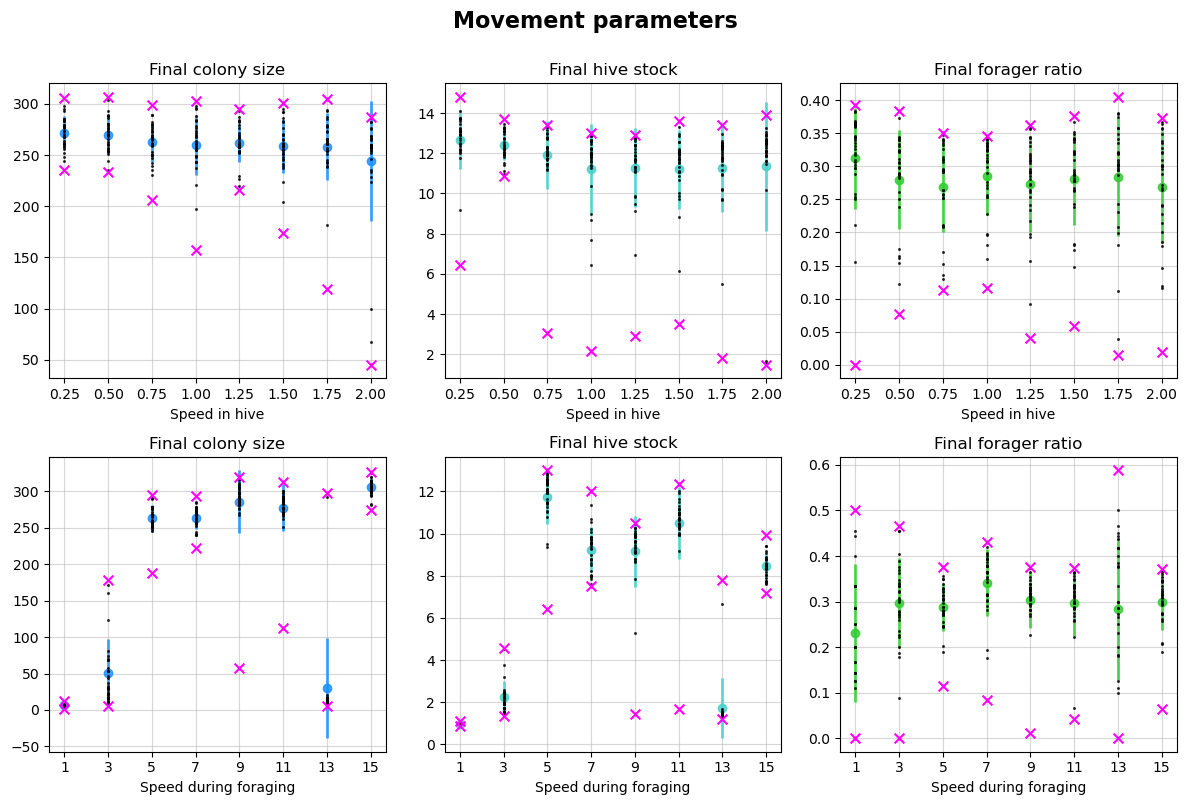

In [33]:
fig, axes = plt.subplots(len(MOVEMENT_PARAMS), len(DATA_COLLECTORS), figsize=(FIGSIZE_SCALE,FIGSIZE_SCALE/3*len(PARAMS)))

PLOT_TITLES = ['Final colony size', 'Final hive stock', 'Final forager ratio']
AXIS_LABELS = ['Speed in hive', 'Speed during foraging']

for (i, PARAM) in enumerate(MOVEMENT_PARAMS):
    DATA = np.load(os.path.join(SAVE_PATH, PARAM + ".npy"))
    DOMAIN = np.linspace(PROBLEM['bounds'][2 + i][0], PROBLEM['bounds'][2 + i][1], N_SAMPLES)

    for X_POINT in DOMAIN:
        DATA_CHUNK = DATA[DATA[:, 0] == X_POINT]

        for (k, ax) in enumerate(axes[i]):

            # Mean and standard deviation
            ax.errorbar(X_POINT, np.mean(DATA_CHUNK[:, k + 1]), np.std(DATA_CHUNK[:, k + 1]), fmt="o", color=f"{PLOT_COLORS[k]}", lw=2.0, alpha=0.85)

            # All data point
            for Y_POINT in DATA_CHUNK[:, k + 1]:
                ax.scatter(X_POINT, Y_POINT, c='k', s=1.5, zorder=10, alpha=0.7)
            
            # Min and max
            ax.scatter(X_POINT, np.max(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')
            ax.scatter(X_POINT, np.min(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')

    for j, (name, ax) in enumerate(zip(PLOT_TITLES, axes[i])):
        ax.grid(alpha=0.5)
        ax.set_xticks(DOMAIN)
        ax.ticklabel_format(axis='x', style='scientific', scilimits=(-3,3))
        ax.set_xlabel(AXIS_LABELS[i])
        ax.set_title(PLOT_TITLES[j])


plt.suptitle('Movement parameters', weight='bold', y=1.0, fontsize=16)
fig.tight_layout()
plt.savefig(FIGURE_PATH + "sa_movement.png")
plt.show()

In [34]:
from ofat_sensitivity_analysis_bee_parameters import IN_HIVE_BEHAVIOUR_PARAMS

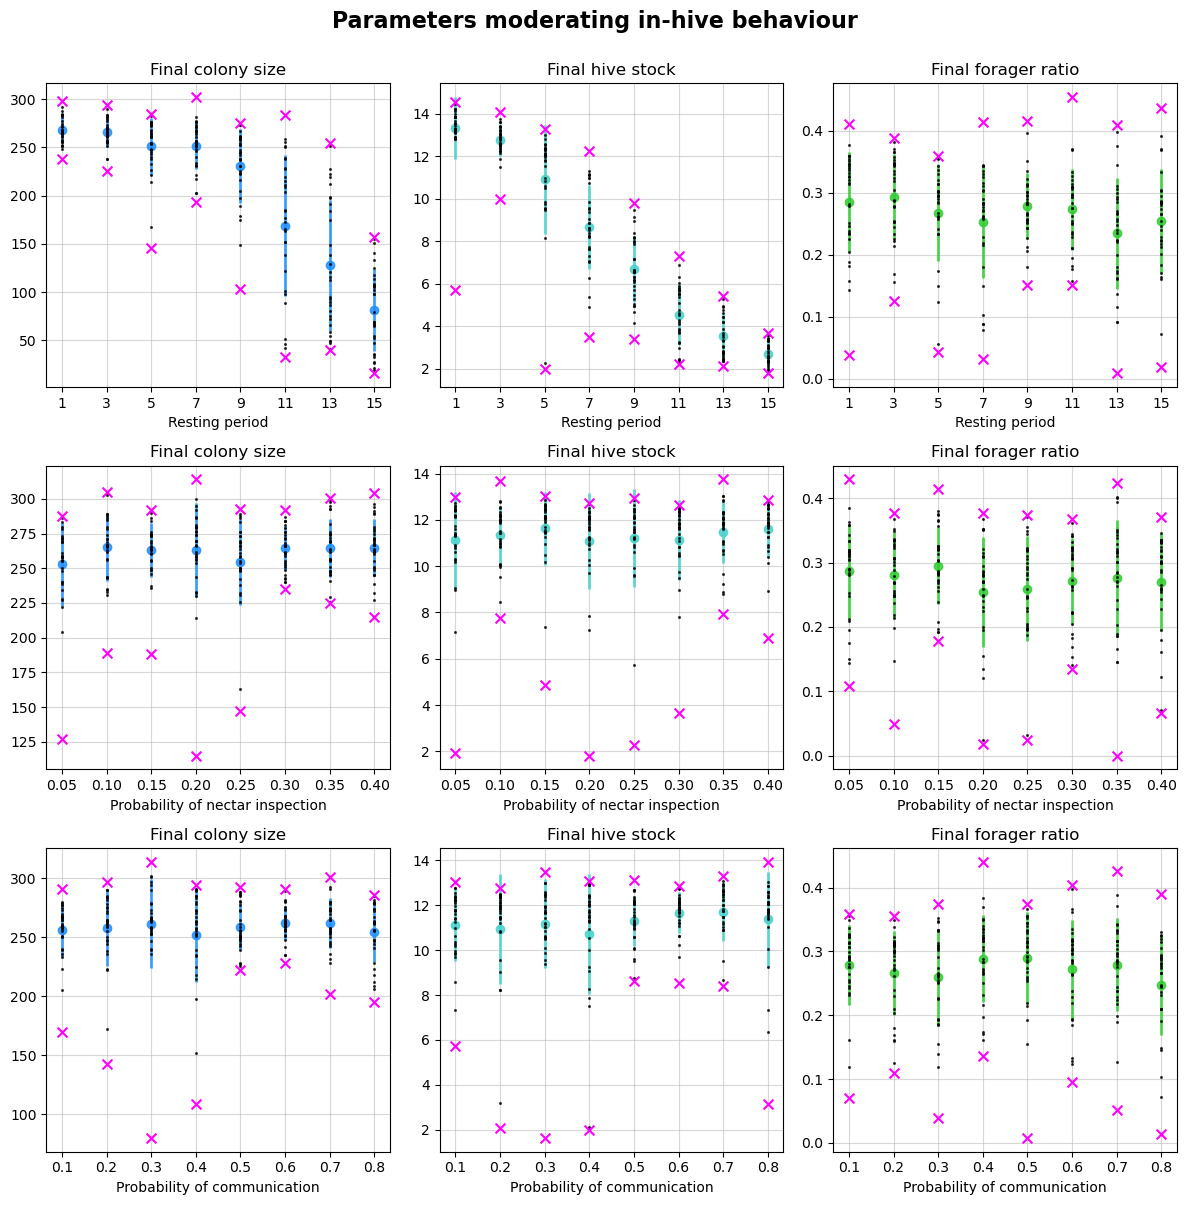

In [35]:
fig, axes = plt.subplots(len(IN_HIVE_BEHAVIOUR_PARAMS), len(DATA_COLLECTORS), figsize=(FIGSIZE_SCALE,FIGSIZE_SCALE/3*len(IN_HIVE_BEHAVIOUR_PARAMS)))

PLOT_TITLES = ['Final colony size', 'Final hive stock', 'Final forager ratio']
AXIS_LABELS = ['Resting period', 'Probability of nectar inspection', 'Probability of communication',]

for (i, PARAM) in enumerate(IN_HIVE_BEHAVIOUR_PARAMS):
    DATA = np.load(os.path.join(SAVE_PATH, PARAM + ".npy"))
    DOMAIN = np.linspace(PROBLEM['bounds'][4 + i][0], PROBLEM['bounds'][4 + i][1], N_SAMPLES)

    for X_POINT in DOMAIN:
        DATA_CHUNK = DATA[DATA[:, 0] == X_POINT]

        for (k, ax) in enumerate(axes[i]):

            # Mean and standard deviation
            ax.errorbar(X_POINT, np.mean(DATA_CHUNK[:, k + 1]), np.std(DATA_CHUNK[:, k + 1]), fmt="o", color=f"{PLOT_COLORS[k]}", lw=2.0, alpha=0.85)

            # All data point
            for Y_POINT in DATA_CHUNK[:, k + 1]:
                ax.scatter(X_POINT, Y_POINT, c='k', s=1.5, zorder=10, alpha=0.7)
            
            # Min and max
            ax.scatter(X_POINT, np.max(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')
            ax.scatter(X_POINT, np.min(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')

    for j, (name, ax) in enumerate(zip(PLOT_TITLES, axes[i])):
        ax.grid(alpha=0.5)
        ax.set_xticks(DOMAIN)
        ax.ticklabel_format(axis='x', style='scientific', scilimits=(-3,3))
        ax.set_xlabel(AXIS_LABELS[i])
        ax.set_title(PLOT_TITLES[j])


plt.suptitle('Parameters moderating in-hive behaviour', weight='bold', y=1.0, fontsize=16)
fig.tight_layout()
plt.savefig(FIGURE_PATH + "sa_inhive.png")
plt.show()

In [36]:
from ofat_sensitivity_analysis_bee_parameters import EXPLORATION_AND_RECRUITMENT_PARAMS

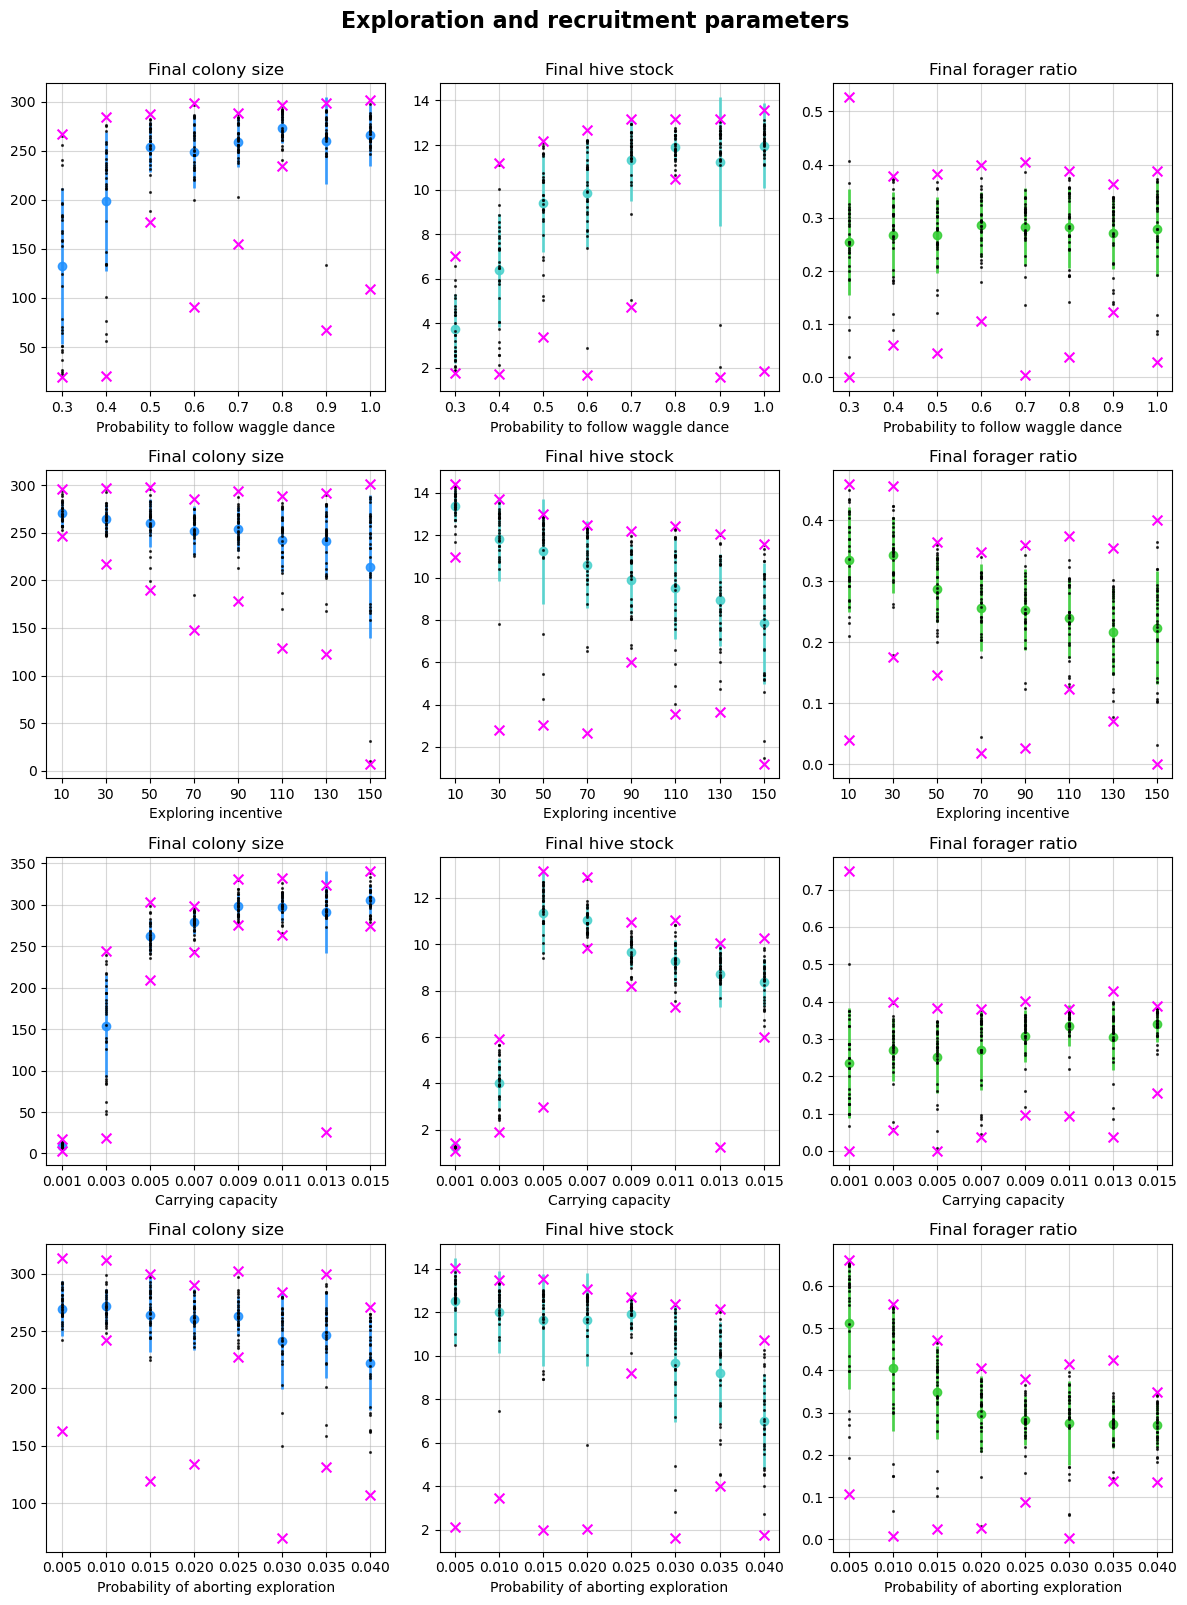

In [37]:
fig, axes = plt.subplots(len(EXPLORATION_AND_RECRUITMENT_PARAMS), len(DATA_COLLECTORS), figsize=(FIGSIZE_SCALE,FIGSIZE_SCALE/3*len(EXPLORATION_AND_RECRUITMENT_PARAMS)))

PLOT_TITLES = ['Final colony size', 'Final hive stock', 'Final forager ratio']
AXIS_LABELS = ['Probability to follow waggle dance', 'Exploring incentive', 'Carrying capacity', 'Probability of aborting exploration']

for (i, PARAM) in enumerate(EXPLORATION_AND_RECRUITMENT_PARAMS):
    DATA = np.load(os.path.join(SAVE_PATH, PARAM + ".npy"))
    DOMAIN = np.linspace(PROBLEM['bounds'][7 + i][0], PROBLEM['bounds'][7 + i][1], N_SAMPLES)

    for X_POINT in DOMAIN:
        DATA_CHUNK = DATA[DATA[:, 0] == X_POINT]

        for (k, ax) in enumerate(axes[i]):

            # Mean and standard deviation
            ax.errorbar(X_POINT, np.mean(DATA_CHUNK[:, k + 1]), np.std(DATA_CHUNK[:, k + 1]), fmt="o", color=f"{PLOT_COLORS[k]}", lw=2.0, alpha=0.85)

            # All data point
            for Y_POINT in DATA_CHUNK[:, k + 1]:
                ax.scatter(X_POINT, Y_POINT, c='k', s=1.5, zorder=10, alpha=0.7)
            
            # Min and max
            ax.scatter(X_POINT, np.max(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')
            ax.scatter(X_POINT, np.min(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')

    for j, (name, ax) in enumerate(zip(PLOT_TITLES, axes[i])):
        ax.grid(alpha=0.5)
        ax.set_xticks(DOMAIN)
        ax.ticklabel_format(axis='x', style='scientific', scilimits=(-3,3))
        ax.set_xlabel(AXIS_LABELS[i])
        ax.set_title(PLOT_TITLES[j])


plt.suptitle('Exploration and recruitment parameters', weight='bold', y=1.0, fontsize=16)
fig.tight_layout()
plt.savefig(FIGURE_PATH + "sa_exploration_recruitment.png")
plt.show()

In [38]:
from ofat_sensitivity_analysis_bee_parameters import BIRTH_AND_DEATH_PARAMS

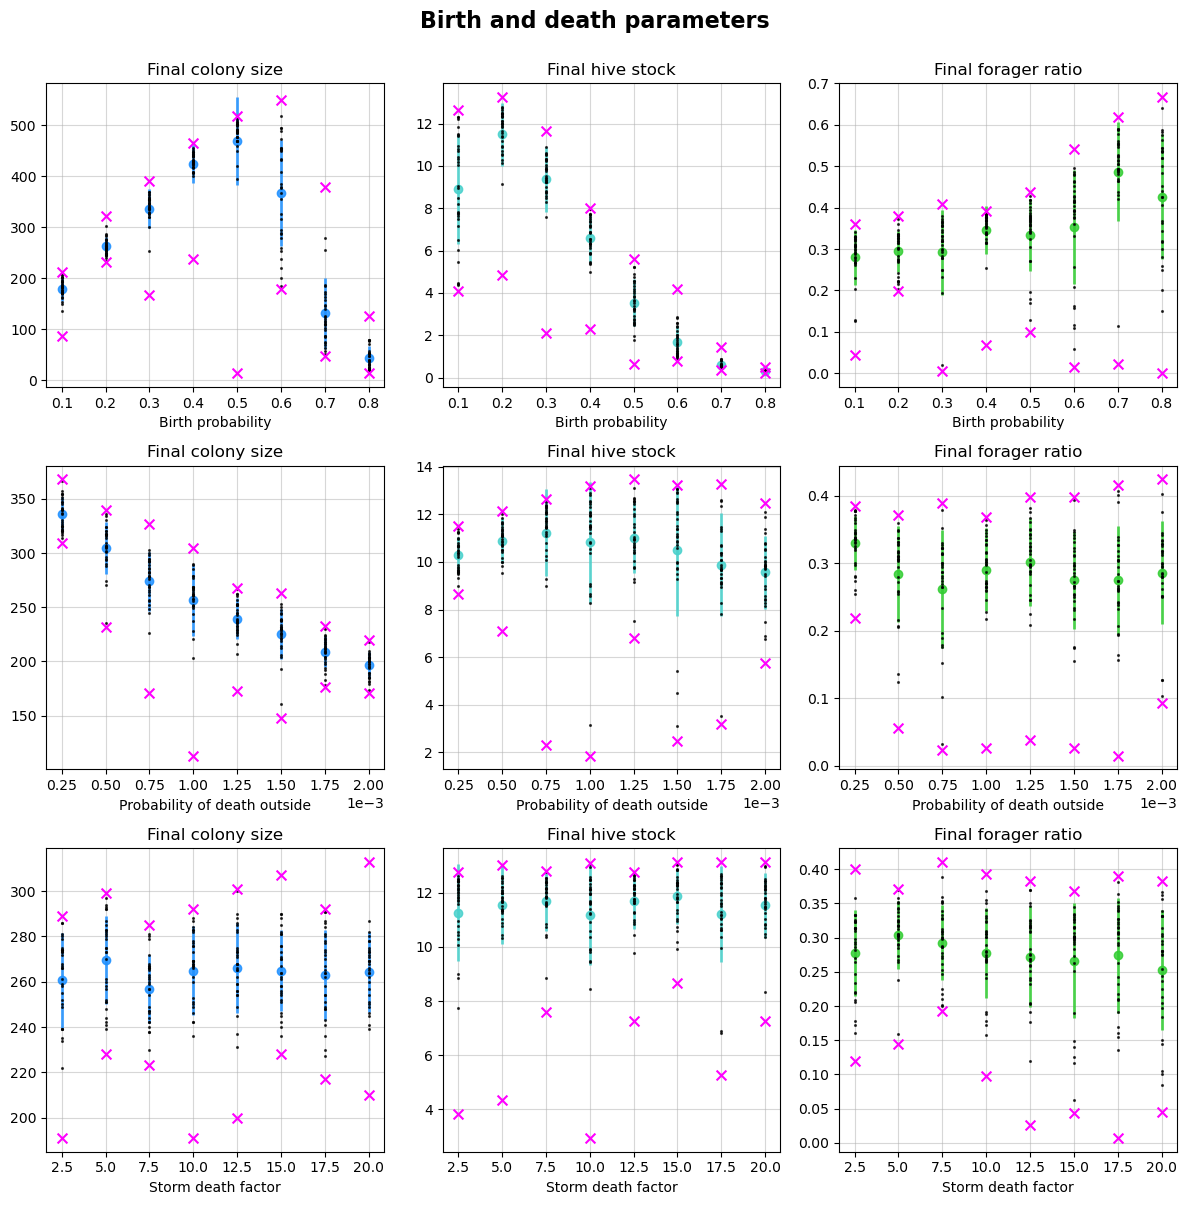

In [39]:
fig, axes = plt.subplots(len(BIRTH_AND_DEATH_PARAMS), len(DATA_COLLECTORS), figsize=(FIGSIZE_SCALE,FIGSIZE_SCALE/3*len(BIRTH_AND_DEATH_PARAMS)))

PLOT_TITLES = ['Final colony size', 'Final hive stock', 'Final forager ratio']
AXIS_LABELS = ['Birth probability', 'Probability of death outside', 'Storm death factor']

for (i, PARAM) in enumerate(BIRTH_AND_DEATH_PARAMS):
    DATA = np.load(os.path.join(SAVE_PATH, PARAM + ".npy"))
    DOMAIN = np.linspace(PROBLEM['bounds'][11 + i][0], PROBLEM['bounds'][11 + i][1], N_SAMPLES)

    for X_POINT in DOMAIN:
        DATA_CHUNK = DATA[DATA[:, 0] == X_POINT]

        for (k, ax) in enumerate(axes[i]):

            # Mean and standard deviation
            ax.errorbar(X_POINT, np.mean(DATA_CHUNK[:, k + 1]), np.std(DATA_CHUNK[:, k + 1]), fmt="o", color=f"{PLOT_COLORS[k]}", lw=2.0, alpha=0.85)

            # All data point
            for Y_POINT in DATA_CHUNK[:, k + 1]:
                ax.scatter(X_POINT, Y_POINT, c='k', s=1.5, zorder=10, alpha=0.7)
            
            # Min and max
            ax.scatter(X_POINT, np.max(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')
            ax.scatter(X_POINT, np.min(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')

    for j, (name, ax) in enumerate(zip(PLOT_TITLES, axes[i])):
        ax.grid(alpha=0.5)
        ax.set_xticks(DOMAIN)
        ax.ticklabel_format(axis='x', style='scientific', scilimits=(-3,3))
        ax.set_xlabel(AXIS_LABELS[i])
        ax.set_title(PLOT_TITLES[j])

plt.suptitle('Birth and death parameters', weight='bold', y=1.0, fontsize=16)
fig.tight_layout()
plt.savefig(FIGURE_PATH + "sa_birth_death.png")
plt.show()